<a href="https://colab.research.google.com/github/MS-2019-Git/EVA4PhaseII/blob/master/S4_Face_Recognition_Part2/FacialRecognizerClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd "//content/gdrive/My Drive/Colab Notebooks/EVA4/EVA4_PhaseII"
import sys
workingdir = '/content/gdrive/My Drive/Colab Notebooks/EVA4/EVA4_PhaseII'
sys.path.append(workingdir)

/content/gdrive/My Drive/Colab Notebooks/EVA4/EVA4_PhaseII


In [3]:
ls -ltr

total 238711
-rw------- 1 root root     69502 Jul 26 17:09 MNIST_Pytorch.ipynb
-rw------- 1 root root    144213 Jul 31 06:59 Session2_custom_dataset.ipynb
-rw------- 1 root root    843247 Aug  5 19:56 Session2_TransferLearning.ipynb
-rw------- 1 root root 243346528 Aug 24 14:10 lfw-funneled.tgz
-rw------- 1 root root     11380 Aug 24 14:14 inception_resnet_v1.py
drwx------ 2 root root      4096 Aug 27 03:38 lfw_funneled/
drwx------ 2 root root      4096 Aug 27 03:40 OutputData/
drwx------ 2 root root      4096 Aug 27 04:19 models_1/
-rw------- 1 root root     11541 Aug 27 06:07 FacialRecognizerClassifier.ipynb


In [4]:
## To unzip dataset folder from Google drive to Colab Content
!tar -xvf  'lfw-funneled.tgz' # -C '/content/'

Streaming output truncated to the last 5000 lines.
lfw_funneled/Delphine_Chuillot/
lfw_funneled/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw_funneled/Paul_LeClerc/
lfw_funneled/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw_funneled/Eddie_Jordan/
lfw_funneled/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw_funneled/Lionel_Richie/
lfw_funneled/Lionel_Richie/Lionel_Richie_0001.jpg
lfw_funneled/Lionel_Richie/Lionel_Richie_0002.jpg
lfw_funneled/Jose_Viegas_Filho/
lfw_funneled/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw_funneled/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw_funneled/Roger_Mahony/
lfw_funneled/Roger_Mahony/Roger_Mahony_0001.jpg
lfw_funneled/Clay_Aiken/
lfw_funneled/Clay_Aiken/Clay_Aiken_0001.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0002.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0003.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0004.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0005.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0006.jpg
lfw_funneled/Edward_Egan/
lfw_funneled/Edward_Egan/Edward_Egan_0001.j

In [ ]:
##To Check the count of images in each sub directory/folder
import glob
import os
#number_files=0
#folder='/content/lfw_funneled'
subfolders = [ f.path for f in os.scandir(folder) if f.is_dir() ]
for dir in subfolders:
  os.chdir(dir)
  myFiles = glob.glob('*.*')
  name=os.path.basename(dir)
  number_files = len(myFiles)
  print (name,number_files)

In [6]:
pip install split-folders tqdm

In [7]:
import splitfolders
input_folder ='/content/gdrive/My Drive/Colab Notebooks/EVA4/EVA4_PhaseII/lfw_funneled'
output = '/content/gdrive/My Drive/Colab Notebooks/EVA4/EVA4_PhaseII/OutputData' #where you want the split datasets saved. one will be created if none is set

splitfolders.ratio(input_folder, output, seed=42, ratio=(.70, .30))

Copying files: 13243 files [05:52, 37.53 files/s]


In [8]:
pip install facenet-pytorch

     |████████████████████████████████| 1.9MB 7.3MB/s 


In [9]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
#from models.inception_resnet_v1 import InceptionResnetV1
from facenet_pytorch import MTCNN, InceptionResnetV1
import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = '/content/gdrive/My Drive/Colab Notebooks/EVA4/EVA4_PhaseII/OutputData'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=8, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

['AJ_Cook',
 'AJ_Lamas',
 'Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abba_Eban',
 'Abbas_Kiarostami',
 'Abdel_Aziz_Al-Hakim',
 'Abdel_Madi_Shabneh',
 'Abdel_Nasser_Assidi',
 'Abdoulaye_Wade',
 'Abdul_Majeed_Shobokshi',
 'Abdul_Rahman',
 'Abdulaziz_Kamilov',
 'Abdullah',
 'Abdullah_Ahmad_Badawi',
 'Abdullah_Gul',
 'Abdullah_Nasseef',
 'Abdullah_al-Attiyah',
 'Abdullatif_Sener',
 'Abel_Aguilar',
 'Abel_Pacheco',
 'Abid_Hamid_Mahmud_Al-Tikriti',
 'Abner_Martinez',
 'Abraham_Foxman',
 'Aby_Har-Even',
 'Adam_Ant',
 'Adam_Freier',
 'Adam_Herbert',
 'Adam_Kennedy',
 'Adam_Mair',
 'Adam_Rich',
 'Adam_Sandler',
 'Adam_Scott',
 'Adel_Al-Jubeir',
 'Adelina_Avila',
 'Adisai_Bodharamik',
 'Adolfo_Aguilar_Zinser',
 'Adolfo_Rodriguez_Saa',
 'Adoor_Gopalakarishnan',
 'Adrian_Annus',
 'Adrian_Fernandez',
 'Adrian_McPherson',
 'Adrian_Murrell',
 'Adrian_Nastase',
 'Adriana_Lima',
 'Adriana_Perez_Navarro',
 'Adrianna_Zuzic',
 

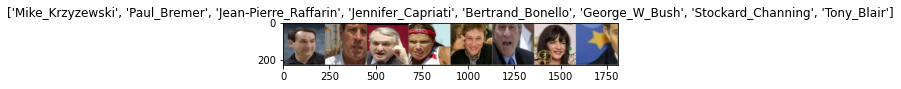

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [13]:
#from models.inception_resnet_v1 import InceptionResnetV1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Running on device: {}'.format(device))

model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(class_names))

Running on device: cuda:0


In [ ]:
model_ft

In [14]:
list(model_ft.children())[-6:]

[Block8(
   (branch0): BasicConv2d(
     (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU()
   )
   (branch1): Sequential(
     (0): BasicConv2d(
       (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (1): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (2): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
   )
   (conv2d): Conv2d(384, 1792,

In [15]:
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [16]:
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

In [17]:
for param in model_ft.parameters():
    param.requires_grad = False

In [18]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(1, -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [19]:
layer_list[3]

BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)

In [26]:
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model_ft.logits = nn.Linear(512, len(class_names))
model_ft.softmax = nn.Softmax(dim=0)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)
# Decay LR by a factor of *gamma* every *step_size* epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# **TRAIN**

In [24]:
def train_model(model, criterion, optimizer, scheduler,num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
    # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() /dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

In [30]:
model_ft.summary()

ModuleAttributeError: ignored

# **EVALUATE**

In [27]:
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------


RuntimeError: ignored